In [1]:
import json
import pandas as pd
import numpy as np
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
from sklearn.cluster import KMeans


load the data from other notebooks

In [2]:
with open('Seattle_geo.json') as json_data:
    seattle_geo = json.load(json_data)

In [3]:
neighborhoods = pd.read_csv('neighborhoods.csv')
neighborhoods = neighborhoods[neighborhoods['City'] == "Seattle"].reset_index(drop = True)
neighborhoods.drop(columns = 'Boundary Box', axis = 1, inplace = True)
neighborhoods.head()

,City,State,Neighborhood,Latitude,Longitude,Home Ownership,Home Rentership,Home Value,Median Age,Population Denisty
0,Seattle,WA,Pinehurst,47.7229,-122.319553,0.501717,0.449341,316608,40.640000,7337.190000
1,Seattle,WA,Brighton,47.5388,-122.275673,0.507302,0.417650,300768,35.843750,11462.300000
2,Seattle,WA,Whittier Heights,47.6833,-122.371407,0.607438,0.347283,398769,39.457143,10478.685714
3,Seattle,WA,Windermere,47.6701,-122.262675,0.655355,0.284598,646423,42.383333,6346.766667
4,Seattle,WA,Loyal Heights,47.6832,-122.384869,0.605153,0.344069,415631,40.529412,10233.158824


In [4]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="sea_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


In [6]:
# create map of Seattle using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  
    
map_seattle

## Explore Ballard

Get Ballard's latitute and longitute values

In [7]:
neighborhood_latitude = neighborhoods.loc[45, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[45, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[45, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Ballard are 47.6665, -122.37605187700001.


Create the url for searching foursquare

In [43]:
CLIENT_ID = 'xxxxxCLIENTIDxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxCLEINTSECRETxxxxx' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xxxxxCLIENTIDxxxxxx
CLIENT_SECRET:xxxxxCLEINTSECRETxxxxx


In [9]:
# limit search to 100 venues
limit = 100
# with 500 m of center of neighborhood
radius = 750
# create url
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={neighborhood_latitude},{neighborhood_longitude}&radius={radius}&limit={limit}'


send the GET request

In [10]:
results = requests.get(url).json()
results


{'meta': {'code': 200, 'requestId': '5e794f5960ba08001b770260'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Ballard',
  'headerFullLocation': 'Ballard, Seattle',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 154,
  'suggestedBounds': {'ne': {'lat': 47.67325000675,
    'lng': -122.36604748879174},
   'sw': {'lat': 47.659749993249996, 'lng': -122.38605626520828}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4f1c60f5e4b04ae084158528',
       'name': "Reuben's Brews",
       'location': {'address': '5010 14th Ave NW',
        'crossStreet': 'at NW 51st St',
        'lat': 47.665398,
        'lng': -122.37327,
        '

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
venues = results['response']['groups'][0]['items']
    
# nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues = pd.json_normalize(venues)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Reuben's Brews,Brewery,47.665398,-122.373270
1,Lagunitas Seattle Taproom & Beer Sanctuary,Brewery,47.664548,-122.378057
2,Mighty-O Donuts,Donut Shop,47.668542,-122.378819
3,Stoup Brewing,Brewery,47.666551,-122.371277
4,Lux Pot Shop,Marijuana Dispensary,47.664877,-122.378686


In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


This is what makes Ballard Great

In [14]:
nearby_venues.categories.unique()

array(['Brewery', 'Donut Shop', 'Marijuana Dispensary', 'Pet Store',
       'Gaming Cafe', 'Toy / Game Store', 'Vegetarian / Vegan Restaurant',
       'Hot Dog Joint', 'Sandwich Place', 'Beer Bar', 'Yoga Studio',
       'Supermarket', 'Grocery Store', 'Seafood Restaurant',
       'Vietnamese Restaurant', 'Mexican Restaurant',
       'New American Restaurant', 'Clothing Store', 'Post Office',
       'Pizza Place', 'Food & Drink Shop', 'Gymnastics Gym', 'Gym',
       'Rock Club', 'Boutique', 'Coffee Shop', 'Noodle House',
       'Furniture / Home Store', 'Food Truck', 'Wine Bar',
       'Mediterranean Restaurant', 'Hotel', 'French Restaurant', 'Bar',
       'Farmers Market', 'Miscellaneous Shop', 'BBQ Joint',
       'Cocktail Bar', 'Ice Cream Shop', 'Garden Center',
       'Italian Restaurant', 'Spa', 'Sporting Goods Shop', 'Cupcake Shop',
       'Warehouse Store', 'Thai Restaurant', 'Sushi Restaurant',
       'Tea Room', 'Record Shop', 'Salon / Barbershop', 'Dessert Shop',
       'Movie

In [15]:
# create map of Seattle using latitude and longitude values
map_ballard = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15, tiles = 'Stamen Toner')

# add markers to map
for lat, lng, name, category in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
    label = f'{name}, {category}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ballard)  
    
map_ballard

In [16]:
ballard_venues = pd.get_dummies(nearby_venues[['categories']], prefix="", prefix_sep="")
ballard_venues['Neighborhood'] = 'Ballard'
ballard_venues.groupby('Neighborhood').mean()

,BBQ Joint,Bar,Beer Bar,Beer Garden,Boutique,Brewery,Burger Joint,Clothing Store,Cocktail Bar,Coffee Shop,...,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Ballard,0.01,0.04,0.01,0.01,0.01,0.09,0.01,0.01,0.04,0.07,...,0.01,0.04,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01


Let's do all of Seattle

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
seattle_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                 radius = 1000
                                  )


Pinehurst
Brighton
Whittier Heights
Windermere
Loyal Heights
North Beach
Roosevelt
Pioneer Square
Westlake
Sand Point
South Park
Maple Leaf
Sunset Hill
Beacon Hill
Rainier Beach
Broadmoor
Madison Park
High Point
Interbay
View Ridge
Matthews Beach
Wedgwood
South Lake Union
Fauntleroy
Capitol Hill
First Hill
Arbor Heights
Northgate
Lower Queen Anne
Eastlake
Mount Baker
Haller Lake
Meadowbrook
Downtown
Admiral
North College Park
Queen Anne
Atlantic
Denny-Blaine
Madison Valley
Central District
International District
Industrial District
University District
Blue Ridge
Ballard
Portage Bay
Roxhill
North Delridge
Highland Park
Fremont
Wallingford
Hawthorne Hills
Greenwood
Leschi
Columbia City
Riverview
Montlake
Green Lake
Olympic Hills
Ravenna
Laurelhurst
Crown Hill
Madrona
Broadview
Bitter Lake
Seward Park
Olympic Manor
Bryant
South Delridge
Cedar Park
Victory Heights
Magnolia
Phinney Ridge
West Seattle
Belltown
Alki
Georgetown


In [19]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_onehot['Neighborhood'] = seattle_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

seattle_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()
seattle_grouped

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Admiral,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.040816,0.0,...,0.0,0.0,0.000000,0.020408,0.0,0.0,0.0,0.0,0.000000,0.0
1,Alki,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,Arbor Heights,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,Atlantic,0.0,0.00000,0.0,0.0,0.016393,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,Ballard,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.010000,0.0,0.0,0.0,0.0,0.010000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Wedgwood,0.0,0.03125,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
74,West Seattle,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.020833,0.000000,0.0,0.0,0.0,0.0,0.020833,0.0
75,Westlake,0.0,0.02381,0.0,0.0,0.000000,0.02381,0.0,0.023810,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
76,Whittier Heights,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.011364,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.011364,0.0


In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiral,Coffee Shop,Pub,Salon / Barbershop,Gym / Fitness Center,Pizza Place,American Restaurant,Grocery Store,Juice Bar,Other Great Outdoors,Bar
1,Alki,Coffee Shop,Park,Food Truck,Ice Cream Shop,Clothing Store,Trail,Beach,Seafood Restaurant,Italian Restaurant,Donut Shop
2,Arbor Heights,Other Repair Shop,Trail,Pool,Scenic Lookout,Zoo,Exhibit,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
3,Atlantic,Park,Coffee Shop,Bakery,Bus Stop,Café,Scenic Lookout,Vietnamese Restaurant,Gym / Fitness Center,Sandwich Place,Playground
4,Ballard,Brewery,Coffee Shop,Bar,Sandwich Place,Cocktail Bar,Mexican Restaurant,Sushi Restaurant,Pizza Place,New American Restaurant,Ice Cream Shop


Try to find an elbow or local min/max. Low k doesn't do justice to the separations

In [25]:
seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

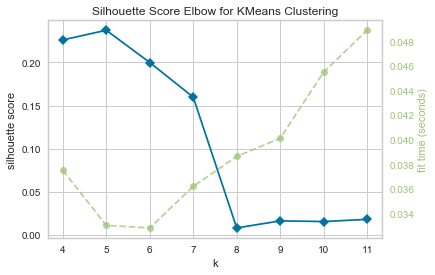

In [31]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='silhouette', timings=True, locate_elbow = False
)

visualizer.fit(seattle_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [40]:
# set number of clusters
kclusters = 7



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 4, 1, 3, 1, 3, 1, 2, 1], dtype=int32)

In [41]:
# add clustering labels
# neighborhoods_venues_sorted.drop(columns = 'Cluster Labels', axis = 1, inplace = True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_ +1) # moving cluster labels up by 1 so it looks nicer in the Legend

seattle_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head() # check the last columns!

,City,State,Neighborhood,Latitude,Longitude,Home Ownership,Home Rentership,Home Value,Median Age,Population Denisty,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Seattle,WA,Pinehurst,47.7229,-122.319553,0.501717,0.449341,316608,40.640000,7337.190000,...,Coffee Shop,Bar,Playground,Pizza Place,Park,Video Store,Rock Club,Dog Run,Gas Station,Thai Restaurant
1,Seattle,WA,Brighton,47.5388,-122.275673,0.507302,0.417650,300768,35.843750,11462.300000,...,Vietnamese Restaurant,Mexican Restaurant,Thai Restaurant,Bakery,Café,Asian Restaurant,Coffee Shop,Seafood Restaurant,Food Truck,Cajun / Creole Restaurant
2,Seattle,WA,Whittier Heights,47.6833,-122.371407,0.607438,0.347283,398769,39.457143,10478.685714,...,Food Truck,Deli / Bodega,Pizza Place,Park,Coffee Shop,Pub,Soccer Field,Bus Station,Thai Restaurant,Shipping Store
3,Seattle,WA,Windermere,47.6701,-122.262675,0.655355,0.284598,646423,42.383333,6346.766667,...,Auto Workshop,Beach,Greek Restaurant,Trail,Bank,Pizza Place,Soccer Field,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
4,Seattle,WA,Loyal Heights,47.6832,-122.384869,0.605153,0.344069,415631,40.529412,10233.158824,...,Pizza Place,Coffee Shop,Bar,Bus Station,Bakery,Convenience Store,Food & Drink Shop,Baseball Field,Restaurant,Furniture / Home Store


map the clusters with choropleth to indicate the cluster. add in a tooltip so the neighborhood can be identified

In [42]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='cartodbpositron')

folium.Choropleth(
    geo_data = seattle_geo,
    data = seattle_merged,
    columns = ['Neighborhood', 'Cluster Labels'],
    key_on = 'feature.id',
    fill_color = 'Set1',
    line_opacty = 0.2,
    legend_name = 'Cluster'
    
).add_to(map_clusters)

for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='black',
        fill=False).add_to(map_clusters)
# folium.LayerControl().add_to(map_clusters)

map_clusters
